In [ ]:
import os
import torch
import json
from PIL import Image
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Working Example: Dog detection

We first used a small dataset based on the example given at https://hackernoon.com/build-a-custom-trained-object-detection-model-with-5-lines-of-code-y08n33vi to check the functionality of the model.

In [ ]:
!pip3 install detecto

### Garbage Detector

This model is very easy to use and can nicely be integrated into other models. However, there is a complication: **The labels are required to be in .XML format.** Therefore, we have to perform custom data loading and preprocessing to generated the required files

In [ ]:
folder_path = "./data"
annotation_file = os.path.join(folder_path, 'annotations.json')
# Key: Unique image id
# Value: 'image': PILImage, 'file_name': unique name for image, 'bbox' = [all boxes]
detect_data = {}
if os.path.exists(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
        for img in data['images']:
            path = os.path.join(folder_path, img['file_name'])

            image = Image.open(path)
            # This is because some images have auto-rotating metadata
            if hasattr(image, '_getexif'):
              orientation = 0x0112  # EXIF orientation tag
              exif = image._getexif()
              if exif is not None and orientation in exif:
                  orientation_value = exif[orientation]
                  if orientation_value == 3:
                      image = image.rotate(180, expand=True)
                  elif orientation_value == 6:
                      image = image.rotate(270, expand=True)
                  elif orientation_value == 8:
                      image = image.rotate(90, expand=True)

            new_name = (img['file_name'].replace('/', '_')).rsplit('.', 1)[0]
            detect_data[img['id']] = {'image': image, 'file_name': new_name, 'bbox': []}

        for annotation in data['annotations']:
            id = annotation['image_id']
            img = detect_data[id]['image']
            bbox = annotation['bbox']
            # bbox needs to be xmin, ymin, xmax, ymax (in original pixels)
            new_bbox = [
                bbox[0],
                bbox[1],
                bbox[0] + bbox[2],
                bbox[1] + bbox[3]
            ]
            detect_data[id]['bbox'].append(new_bbox)

In [ ]:
detect_data

In [ ]:
# for key, value in detect_data.items():
#     file_name = value['file_name']
#     image = value['image']
#     bbox = value['bbox']

#     # Save image as .jpg in the images folder
#     image.save(f"./images/{file_name}.jpg")

In [ ]:
# for key, value in detect_data.items():
#     file_name = value['file_name']
#     image = value['image']
#     bbox = value['bbox']

#     # Generate label file (.xml) in the labels folder
#     xml_content = f'''<annotation>
#         <folder>idk</folder>
#         <filename>{file_name}.jpg</filename>
#         <source>
#             <database>idk</database>
#         </source>
#         <size>
#             <width>{image.width}</width>
#             <height>{image.height}</height>
#             <depth>3</depth>
#         </size>
#         <segment>0</segment>
#     '''
#     for box in bbox:
#         box_str = f'''
#         <object>
#             <name>garbage</name>
#             <pose>Unspecified</pose>
#             <truncated>0</truncated>
#             <difficult>0</difficult>
#             <bndbox>
#                 <xmin>{box[0]}</xmin>
#                 <ymin>{box[1]}</ymin>
#                 <xmax>{box[2]}</xmax>
#                 <ymax>{box[3]}</ymax>
#             </bndbox>
#         </object>'''
#         xml_content += box_str
#     xml_content += "\n</annotation>"

#     label_file_path = f"./images/{file_name}.xml"
#     with open(label_file_path, 'w') as label_file:
#         label_file.write(xml_content)

Now the dataset is set up, we upload the folder to Drive and start the training

In [ ]:
%%shell
cp "/content/drive/MyDrive/APS360 Group8/Detector/detecto_dataset.zip" detect.zip
unzip detect.zip
rm detect.zip

Archive:  detect.zip
   creating: detecto_dataset/batch1/
  inflating: detecto_dataset/batch1/batch_1_000000.jpg  
  inflating: detecto_dataset/batch1/batch_1_000000.xml  
  inflating: detecto_dataset/batch1/batch_1_000001.jpg  
  inflating: detecto_dataset/batch1/batch_1_000001.xml  
  inflating: detecto_dataset/batch1/batch_1_000003.jpg  
  inflating: detecto_dataset/batch1/batch_1_000003.xml  
  inflating: detecto_dataset/batch1/batch_1_000004.jpg  
  inflating: detecto_dataset/batch1/batch_1_000004.xml  
  inflating: detecto_dataset/batch1/batch_1_000005.jpg  
  inflating: detecto_dataset/batch1/batch_1_000005.xml  
  inflating: detecto_dataset/batch1/batch_1_000006.jpg  
  inflating: detecto_dataset/batch1/batch_1_000006.xml  
  inflating: detecto_dataset/batch1/batch_1_000007.jpg  
  inflating: detecto_dataset/batch1/batch_1_000007.xml  
  inflating: detecto_dataset/batch1/batch_1_000008.jpg  
  inflating: detecto_dataset/batch1/batch_1_000008.xml  
  inflating: detecto_dataset/b

In [ ]:
from detecto import core, utils, visualize

train_dataset = core.Dataset('/content/detecto_dataset/train/')
train_loader = core.DataLoader(train_dataset, batch_size=10, shuffle=True)

model = core.Model(['garbage'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
val_dataset = core.Dataset('/content/detecto_dataset/valid/')

In [ ]:
losses = model.fit(train_loader, val_dataset, epochs=10, learning_rate=0.001,
                   lr_step_size=5, verbose=True)

plt.plot(losses)
plt.show()

Epoch 1 of 10
Begin iterating over training dataset


  0%|          | 0/121 [00:04<?, ?it/s]


OutOfMemoryError: ignored

**As you can see, we cannot simply train the entire dataset! =(**

Try workarouind: train around 100 input images at a time (took 2 hours)

In [ ]:
from detecto import core, utils, visualize

model = core.Model(['garbage', 'nothing'])

folder_path = '/content/detecto_dataset'
for entry in os.scandir(folder_path):
  train_dataset = core.Dataset(entry.path)
  losses = model.fit(train_dataset)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 73.2MB/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:37<00:00,  2.71it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:36<00:00,  2.77it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:36<00:00,  2.78it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:37<00:00,  2.69it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:36<00:00,  2.75it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:36<00:00,  2.76it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:37<00:00,  2.69it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:36<00:00,  2.77it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:37<00:00,  2.72it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 101/101 [00:37<00:00,  2.71it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.88it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:08<00:00,  1.85it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.89it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.88it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:08<00:00,  1.86it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.89it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.89it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.88it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.89it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 127/127 [01:07<00:00,  1.89it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:53<00:00,  2.11it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:51<00:00,  2.17it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:52<00:00,  2.14it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:54<00:00,  2.06it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:52<00:00,  2.15it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:52<00:00,  2.12it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:53<00:00,  2.11it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:51<00:00,  2.16it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:53<00:00,  2.11it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 112/112 [00:53<00:00,  2.11it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:41<00:00,  2.05it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:40<00:00,  2.10it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:40<00:00,  2.10it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:41<00:00,  2.06it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:40<00:00,  2.11it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:41<00:00,  2.06it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:39<00:00,  2.13it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:40<00:00,  2.08it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:41<00:00,  2.06it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 85/85 [00:39<00:00,  2.14it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:43<00:00,  2.23it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:43<00:00,  2.24it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:42<00:00,  2.28it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:42<00:00,  2.26it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:43<00:00,  2.24it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:43<00:00,  2.22it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:42<00:00,  2.27it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:42<00:00,  2.26it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:43<00:00,  2.23it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:43<00:00,  2.23it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:41<00:00,  2.15it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:41<00:00,  2.13it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:42<00:00,  2.11it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:41<00:00,  2.15it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:41<00:00,  2.14it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:42<00:00,  2.11it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:41<00:00,  2.15it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:41<00:00,  2.13it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:42<00:00,  2.10it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 89/89 [00:41<00:00,  2.15it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:42<00:00,  2.17it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:42<00:00,  2.15it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:43<00:00,  2.13it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:42<00:00,  2.18it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:42<00:00,  2.16it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:42<00:00,  2.14it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:43<00:00,  2.14it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:41<00:00,  2.21it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:43<00:00,  2.14it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 92/92 [00:43<00:00,  2.09it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:45<00:00,  2.13it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:45<00:00,  2.14it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:46<00:00,  2.10it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:45<00:00,  2.14it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:45<00:00,  2.12it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:45<00:00,  2.13it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


#### Inference

In [ ]:
import matplotlib.patches as patches
from array import array
def draw(image, boxes):
  plt.imshow(image)
  for box in boxes:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
  plt.show()

['garbage', 'garbage', 'garbage', 'garbage', 'garbage', 'garbage']
tensor([[1283.1776, 1629.2449, 1624.3568, 1992.8889],
        [1005.7116, 1625.5601, 1637.2484, 2436.2849],
        [ 928.8864, 1928.5095, 1397.8903, 2475.6013],
        [1170.2701, 1979.0022, 1372.1044, 2210.2407],
        [1184.9613, 2012.0054, 1300.1361, 2136.6265],
        [1180.1259, 2114.5950, 1234.7992, 2153.6543]])
tensor([0.7268, 0.4039, 0.2135, 0.1556, 0.0820, 0.0567])


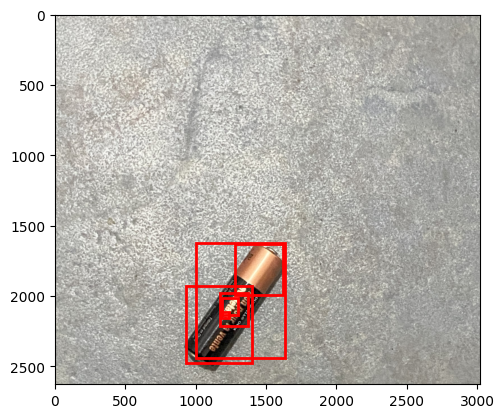

In [ ]:
test_path = '/content/drive/MyDrive/APS360 Group8/Custom Test Images/battery/battery8.jpg'
test_image = utils.read_image(test_path)
predictions = model.predict(test_image)

labels, boxes, scores = predictions

print(labels)
print(boxes)
print(scores)

draw(test_image, boxes)

In [ ]:
model.save('model.pth')

Observe that the model didn't do so good, especially in more vague images.